In [1]:
import torch
from diffusers import StableDiffusionPipeline
from consistencydecoder import ConsistencyDecoder, save_image, load_image, _extract_into_tensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from modules.models.decoding.openai_decoder import DiffusionDecoder

def transf(image):
    image = image[0].cpu().numpy()
    image = (image + 1.0) * 127.5
    image = image.clip(0, 255).astype(np.uint8)
    image = Image.fromarray(image.transpose(1, 2, 0))

    return image

def ldm_transform_latent(z, extra_scale_factor=1):
    channel_means = [0.38862467, 0.02253063, 0.07381133, -0.0171294]
    channel_stds = [0.9654121, 1.0440036, 0.76147926, 0.77022034]

    if len(z.shape) != 4:
        raise ValueError()

    z = z * 0.18215
    channels = [z[:, i] for i in range(z.shape[1])]

    channels = [
        extra_scale_factor * (c - channel_means[i]) / channel_stds[i]
        for i, c in enumerate(channels)
    ]
    return torch.stack(channels, dim=1)

/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate Latents

In [2]:
# cdd = ConsistencyDecoder(device="cuda:0") # Model size: 2.49 GB
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, device="cuda:0"
)
pipe.unet.cpu()
pipe.vae.cuda()

# image = load_image("people.jpg", size=(1024, 1024), center_crop=True)
# latent1024 = pipe.vae.encode(image.half().cuda()).latent_dist.mean.cpu()
# image = load_image("people.jpg", size=(128, 128), center_crop=True)
# latent128 = pipe.vae.encode(image.half().cuda()).latent_dist.mean.cpu()

Keyword arguments {'device': 'cuda:0'} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [3]:
image = Image.open("people.jpg")
image = np.array(image.convert("RGB"))
image = image[None].transpose(0, 3, 1, 2)
image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
image.shape

torch.Size([1, 3, 417, 626])

In [4]:
latent_m = pipe.vae.encode(image.half().cuda()).latent_dist.mean.cpu()
latent_m.shape


torch.Size([1, 4, 52, 78])

In [3]:
latent128.shape, latent1024.shape

(torch.Size([1, 4, 16, 16]), torch.Size([1, 4, 128, 128]))

# Reconstruct latent without upsampling

In [5]:
del pipe
torch.cuda.empty_cache()

In [6]:
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

model_config = OmegaConf.load("configs/models/consistency_diffusion_decoder.yaml")
diffusion_decoder = instantiate_from_config(model_config.model)
# Load replicated model
cdd = DiffusionDecoder(320)
cdd.load_state_dict(torch.load("cdd_custom.pt"))
cdd = cdd.cuda()
diffusion_decoder.model.diffusion_model = cdd
sampler = instantiate_from_config(model_config.model.params.sampler_config)

Initialized embedder #0: IdentityEncoder with 0 params. Trainable: True


tensor([1.], device='cuda:0')
SCHEDULE TIMESTEPS: [1023, 511]
=> 1023 tensor(20778.1562, device='cuda:0')
STEP: 1023
torch.Size([1024])
torch.Size([1, 1, 1, 1]) tensor([[[[4.8127e-05]]]], device='cuda:0')
=> 511 tensor(1.0124, device='cuda:0')
STEP: 511
torch.Size([1024])
torch.Size([1, 1, 1, 1]) tensor([[[[0.7027]]]], device='cuda:0')


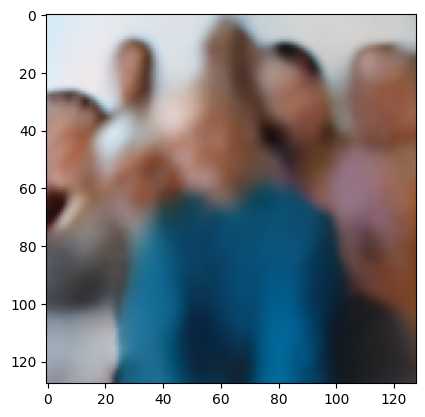

In [ ]:
from generate_new_decoder import generate_from_decoder

features = ldm_transform_latent(latent1024)
diffusion_decoder = diffusion_decoder.cuda()

samples = generate_from_decoder(diffusion_decoder, sampler, features.to("cuda"), img_dims=128).to("cuda")
plt.imshow(samples.cpu().numpy()[0].transpose(1, 2, 0))

In [12]:
latent_m.shape[3] * 8

624

torch.Size([1, 4, 416, 624])
torch.Size([1, 3, 416, 624]) (1, 3, 416, 624) 416 624


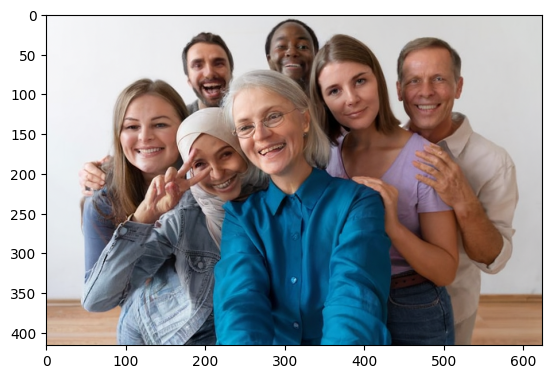

In [7]:
from generate_new_decoder import generate_from_decoder
import torch.nn.functional as F
# ([1, 4, 52, 78])
upscale_factor = 2 ** (4-1)
z = F.interpolate(latent_m.float(), mode="nearest", scale_factor=upscale_factor)
        
features = ldm_transform_latent(z)
diffusion_decoder = diffusion_decoder.cuda()

print(features.shape)
samples = generate_from_decoder(diffusion_decoder, sampler, features.to("cuda")).to("cuda")
plt.imshow(samples.cpu().numpy()[0].transpose(1, 2, 0))

In [11]:
z.shape

torch.Size([1, 4, 416, 624])

In [9]:
from modules.sampling import CDDSampler
n = 4
max_ = 1.0
min_ = 0.0
sampler = CDDSampler(
    num_steps=1024,
    schedule=torch.arange(min_ + max_/n, max_ + max_/n, max_/n),
    discretization_config=model_config.model.params.sampler_config.params.discretization_config,
    guider_config=model_config.model.params.sampler_config.params.guider_config,
)
sampler

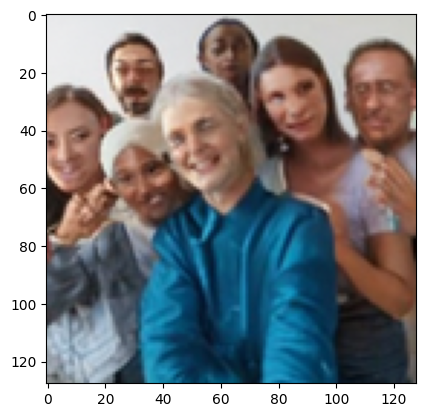

In [10]:
import torch.nn.functional as F
from generate_new_decoder import generate_from_decoder

upscale_factor = 2 ** (4-1)
z = F.interpolate(latent128.float(), mode="nearest", scale_factor=upscale_factor)
        
features = ldm_transform_latent(z)
diffusion_decoder = diffusion_decoder.cuda()

samples = generate_from_decoder(diffusion_decoder, sampler, features.to("cuda"), img_dims=128).to("cuda")
plt.imshow(samples.cpu().numpy()[0].transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


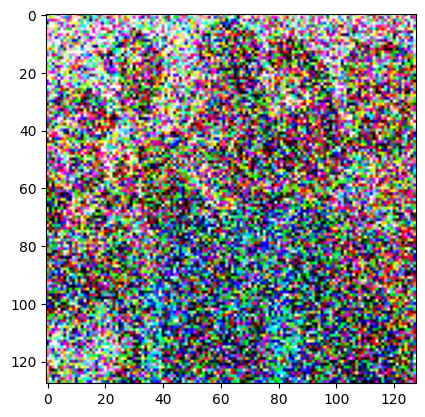

In [15]:
shape = (1, 3, 128, 128)
random_noise = torch.randn(shape).to("cpu")

plt.imshow((samples.cpu() + random_noise*0.7).numpy()[0].transpose(1, 2, 0))

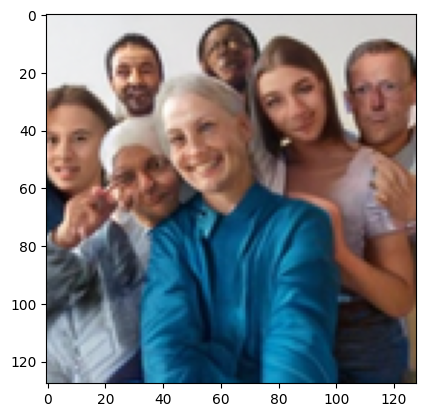

In [18]:
shape = (1, 3, 128, 128)
random_noise = torch.randn(shape).to("cuda")
noisy_sample = samples + random_noise*0.5

upscale_factor = 2 ** (4-1)
z = F.interpolate(latent128.float(), mode="nearest", scale_factor=upscale_factor)
        
features = ldm_transform_latent(z)
diffusion_decoder = diffusion_decoder.cuda()

samples = generate_from_decoder(
    diffusion_decoder, sampler, features.to("cuda"), img_dims=128,
    noise_inp=noisy_sample
).to("cuda")
plt.imshow(samples.cpu().numpy()[0].transpose(1, 2, 0))